In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torchsummary import summary
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare the dataset

In [ ]:
!gdown --id 13Q-n32Bkf8-njeTkV2c-MaWb5S0byowq
!mkdir atml-assignment-3
!unzip atml-assignment-3-data.zip -d atml-assignment-3

In [ ]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [ ]:
class RotationDataset(Dataset):
    def __init__(self, folder_path, phase='unlabel', transform=None):
        super(RotationDataset, self).__init__()
        self.phase = phase
        self.dataset = np.load(os.path.join(folder_path, 'train_32x32_unlabel.npy'))
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        rotation = np.random.randint(4)
        rotated_img = img_index.rotate(rotation * 90)
        return self.transform(rotated_img), rotation

    def __len__(self):
        return self.dataset.shape[0]

In [ ]:
transform = transforms.Compose([
                                transforms.ColorJitter(0.2,0.4,0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_set = LabeledDataset('./atml-assignment-3', phase='train', transform=transform)
val_set   = LabeledDataset('./atml-assignment-3', phase='val',   transform=transform)
test_set  = LabeledDataset('./atml-assignment-3', phase='test',  transform=transform)
unlabel_set = RotationDataset('./atml-assignment-3', phase='unlabel', transform=transform)


batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)
unlabel_loader = DataLoader(unlabel_set, batch_size=batch_size, shuffle=True,  num_workers=2)

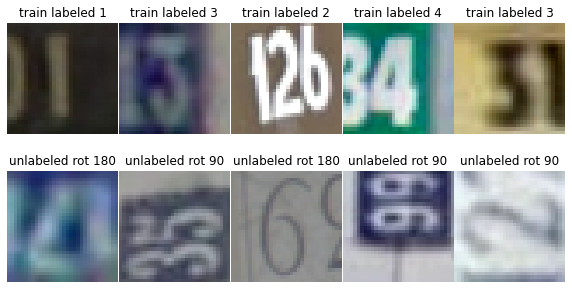

In [ ]:
# Show some examples
fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = [ax for axs in axes for ax in axs]

for j in range(5):
    idx = np.random.randint(0, len(train_set))
    axes[j].imshow(train_set[idx][0].permute(1,2,0)*0.5+0.5)
    axes[j].axis('off')
    axes[j].set_title('train labeled {}'.format(train_set[idx][1]))

    idx = np.random.randint(0, len(unlabel_set))
    img, label = unlabel_set[idx]
    axes[j+5].imshow(img.permute(1,2,0)*0.5+0.5)
    axes[j+5].axis('off')
    axes[j+5].set_title('unlabeled rot {}'.format(label*90))
plt.subplots_adjust(wspace=0.01)

# Define the CNN architecture

In [ ]:
class RotationNet(nn.Module):
    def __init__(self, ndf=64, nc=3, num_classes=10):
        super(RotationNet, self).__init__() 
        self.conv1 = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=3, stride=1, padding=1),    
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.BatchNorm2d(ndf),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential( 
            nn.Conv2d(ndf, ndf*2, 3, 1), 
            nn.MaxPool2d(2, 2), 
            nn.BatchNorm2d(ndf*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Sequential( 
            nn.Conv2d(ndf*2, ndf*4, 3, 1), 
            nn.MaxPool2d(2, 1), 
            nn.BatchNorm2d(ndf*4),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential( 
            nn.Conv2d(ndf*4, ndf*8, 2, 1), 
            nn.BatchNorm2d(ndf*8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.classification_head = nn.Sequential(
            nn.Conv2d(ndf*8, num_classes, 3, 1),
        )
        
    def forward(self, img):
        output = self.conv1(img)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.classification_head(output)
        return output.squeeze(3).squeeze(2)

# Train a self-supervised feature extractor

In [ ]:
def train_model(model, loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        smooth = 0
        model.train()
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels-smooth)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total      += labels.size(0)
            correct    += (predicted == labels).sum().item()

            train_loss = running_loss / len(loader)
            train_accuracy = 100 * correct / total

        print('Epoch %2d. Accuracy of the network on the unlabelled images:: %.3f %%. And loss: %.3f' % (epoch+1, train_accuracy, train_loss))
    return train_loss, train_accuracy

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [ ]:
model = RotationNet(num_classes=4).to(device)

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
noise = torch.randn(16, 3, 32, 32, device=device)
out = model(noise)
print("Model output shape:", out.size())

Model output shape: torch.Size([16, 4])


In [ ]:
train_model(model, unlabel_loader, criterion, optimizer, epochs=20)

Epoch  1. Accuracy of the network on the unlabelled images:: 66.248 %. And loss: 0.917
Epoch  2. Accuracy of the network on the unlabelled images:: 76.622 %. And loss: 0.748
Epoch  3. Accuracy of the network on the unlabelled images:: 79.428 %. And loss: 0.706
Epoch  4. Accuracy of the network on the unlabelled images:: 81.242 %. And loss: 0.679
Epoch  5. Accuracy of the network on the unlabelled images:: 82.420 %. And loss: 0.661
Epoch  6. Accuracy of the network on the unlabelled images:: 83.682 %. And loss: 0.645
Epoch  7. Accuracy of the network on the unlabelled images:: 84.462 %. And loss: 0.633
Epoch  8. Accuracy of the network on the unlabelled images:: 84.980 %. And loss: 0.625
Epoch  9. Accuracy of the network on the unlabelled images:: 85.452 %. And loss: 0.616
Epoch 10. Accuracy of the network on the unlabelled images:: 85.774 %. And loss: 0.609
Epoch 11. Accuracy of the network on the unlabelled images:: 86.513 %. And loss: 0.603
Epoch 12. Accuracy of the network on the un

(0.5688370266098953, 88.7830936795051)

In [ ]:
# save the network parameters
torch.save(model.state_dict(), './model_state.pth')

# Transfer learning

In [ ]:
def train_model_(model, loader, criterion, optimizer):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total      += labels.size(0)
        correct    += (predicted == labels).sum().item()
        train_loss = running_loss / len(loader)
        train_accuracy = 100 * correct / total
    #print('Accuracy of the training: %.3f %%' % (train_accuracy))
    return train_loss, train_accuracy

def evaluate(model, val_loader, criterion):
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)          
            outputs = model(inputs)
            loss = criterion(outputs, labels)              
            _, predicted = torch.max(outputs.data, 1)
            total      += labels.size(0)
            correct    += (predicted == labels).sum().item()
            total_loss += loss.item()
            val_loss = total_loss / len(val_loader)
            val_accuracy = 100 * correct / total
    
    return val_loss, val_accuracy

def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    best_valid_loss = np.inf
    best_model = None
    patience = 15
    coutner  = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_accuracy = train_model_(model, train_loader, criterion, optimizer)
        model.eval()
        valid_loss, valid_accuracy = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        print('Epoch %2d. Accuracy of the network on the 2000 validation images: %.3f %%' % (epoch+1, valid_accuracy))

        if valid_loss < best_valid_loss: # 
            best_valid_loss = valid_loss
            best_model = deepcopy(model)
            counter = 0
        else: counter += 1
        if counter == patience:      
            print('No improvement for {} epochs, training stopped'.format(patience))
            break
    
    for param1, param2 in zip(model.parameters(), best_model.parameters()):
        param1.data = param2.data
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies

def plot(val_acc_fixed, val_acc_fintuned):
    loss_curves = [val_acc_fixed, val_acc_fintuned]
    reg_types   = ['fixed features', 'finetuned features']
    plt.figure(figsize=(12,6))
    for loss_curve in loss_curves:
        plt.plot(np.arange(len(loss_curve)), loss_curve)
    plt.title('Validation accuracies curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(reg_types);

### Fixed feature extractor

In [ ]:
# load trained features
state_dict = torch.load('./model_state.pth')
newModel1 = RotationNet(num_classes=4).to(device)
newModel1.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# extract features of the first 4 layers
features = nn.Sequential(*(list(newModel1.children())[:4]))

# freeze all model parameters
for param in features.parameters():
    param.requires_grad = False
  
# new final layer with 10 classes
newModel1.classification_head = nn.Sequential(nn.Conv2d(512, 10, 3, 1)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(newModel1.parameters(), lr=0.001)

_, _, _, val_acc_fixed = train(newModel1, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch  1. Accuracy of the network on the 2000 validation images: 47.700 %
Epoch  2. Accuracy of the network on the 2000 validation images: 55.050 %
Epoch  3. Accuracy of the network on the 2000 validation images: 60.550 %
Epoch  4. Accuracy of the network on the 2000 validation images: 62.900 %
Epoch  5. Accuracy of the network on the 2000 validation images: 65.700 %
Epoch  6. Accuracy of the network on the 2000 validation images: 68.150 %
Epoch  7. Accuracy of the network on the 2000 validation images: 70.050 %
Epoch  8. Accuracy of the network on the 2000 validation images: 71.900 %
Epoch  9. Accuracy of the network on the 2000 validation images: 72.700 %
Epoch 10. Accuracy of the network on the 2000 validation images: 72.900 %
Epoch 11. Accuracy of the network on the 2000 validation images: 73.550 %
Epoch 12. Accuracy of the network on the 2000 validation images: 74.850 %
Epoch 13. Accuracy of the network on the 2000 validation images: 75.500 %
Epoch 14. Accuracy of the network on t

### Finetuned feature extractor


In [ ]:
# load trained features
state_dict = torch.load('./model_state.pth')
newModel2 = RotationNet(num_classes=4).to(device)
newModel2.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# extract features of the first 4 layers
features = nn.Sequential(*(list(newModel2.children())[:4]))

# unfreeze all model parameters
for param in features.parameters():
    param.requires_grad = True
  
# new final layer with 10 classes
newModel2.classification_head = nn.Sequential(nn.Conv2d(512, 10, 3, 1)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(newModel2.parameters(), lr=0.001)

_, _, _, val_acc_finetuned = train(newModel2, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch  1. Accuracy of the network on the 2000 validation images: 43.500 %
Epoch  2. Accuracy of the network on the 2000 validation images: 56.650 %
Epoch  3. Accuracy of the network on the 2000 validation images: 68.300 %
Epoch  4. Accuracy of the network on the 2000 validation images: 77.100 %
Epoch  5. Accuracy of the network on the 2000 validation images: 79.600 %
Epoch  6. Accuracy of the network on the 2000 validation images: 81.150 %
Epoch  7. Accuracy of the network on the 2000 validation images: 82.200 %
Epoch  8. Accuracy of the network on the 2000 validation images: 82.100 %
Epoch  9. Accuracy of the network on the 2000 validation images: 82.900 %
Epoch 10. Accuracy of the network on the 2000 validation images: 82.200 %
Epoch 11. Accuracy of the network on the 2000 validation images: 82.300 %
Epoch 12. Accuracy of the network on the 2000 validation images: 82.650 %
Epoch 13. Accuracy of the network on the 2000 validation images: 82.950 %
Epoch 14. Accuracy of the network on t

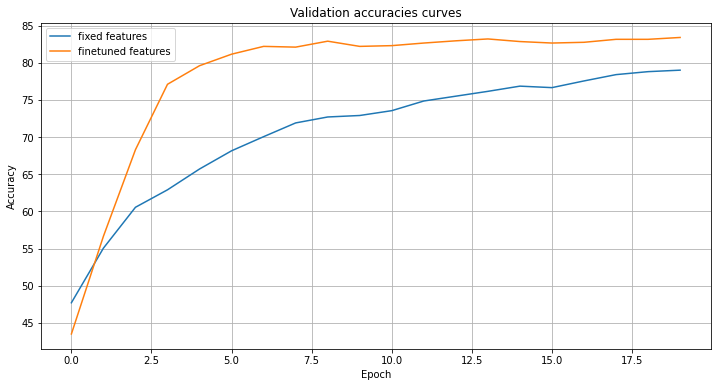

In [ ]:
plot(val_acc_fixed, val_acc_finetuned)